In [ ]:
'''
使用dataset2的数据:
Adam:0.76794
使用dataset1的数据:
Adam:0.77551
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import tensorflow.python.framework as ops
import math
tf.compat.v1.disable_eager_execution()

%matplotlib inline
np.random.seed(1)

In [18]:
logits = tf.constant([[9., 2.], [1, 7.], [5., 4.], [2., 8.]])
labels = tf.constant([0, 1, 0, 1])

one_hot_labels = tf.one_hot(labels, depth = 2, dtype = tf.float32)

loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = one_hot_labels, logits = logits)

sess = tf.Session()
print(sess.run(one_hot_labels))
print(sess.run(loss))

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
1.1991692


In [19]:
Y = np.array([1, 0, 1, 0, 1, 0])
Y = Y.astype(np.float32)
A3 = np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4])
A3 = A3.astype(np.float32)

cost = (-1 / 6) * np.sum(np.multiply(Y, np.log(A3)) + np.multiply((1 - Y), np.log(1 - A3)))
print(cost)
one_hot_labels = tf.one_hot(Y, 6)

loss1 = tf.losses.sigmoid_cross_entropy(Y, A3)
loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = A3, labels = Y))
print(sess.run(loss1))
print(sess.run(loss2))

0.6986227830251057
0.72333676
0.72333676


In [20]:
# 处理过的数据
train_df = pd.read_csv('dataset/over_dataset_1/train.csv')
test_df = pd.read_csv('dataset/over_dataset_1/test.csv')
X_train = train_df.drop('Survived', axis = 1).to_numpy().T
Y_train = train_df['Survived'].to_numpy().reshape(1, -1)
X_test = test_df.drop('PassengerId', axis = 1).to_numpy().T
X_train.shape, Y_train.shape, X_test.shape

((7, 889), (1, 889), (7, 418))

In [21]:
# 归一化操作
def normalization(data):
    m = data.shape[1]
    miu = data.mean(axis = 1).reshape(data.shape[0],1)
    sigma = data.std(axis = 1).reshape(data.shape[0],1)

    data = (data - miu)/sigma

    return data
X_train = normalization(X_train)
X_test = normalization(X_test)

In [22]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    minibatches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        minibatch = (mini_batch_X, mini_batch_Y)
        minibatches.append(minibatch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        minibatch = (mini_batch_X, mini_batch_Y)
        minibatches.append(minibatch)

    return minibatches

In [23]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")

    return X, Y

In [24]:
def initialize_parameters(layers_dims):
    tf.set_random_seed(1)

    xavier_initializer = tf.keras.initializers.GlorotNormal(seed = 1)

    W1 = tf.Variable(initial_value = xavier_initializer(shape = (layers_dims[1], layers_dims[0])), name = "W1")
    b1 = tf.Variable(initial_value = xavier_initializer(shape = (layers_dims[1], 1)), name = "b1")
    W2 = tf.Variable(initial_value = xavier_initializer(shape = (layers_dims[2], layers_dims[1])), name = "W2")
    b2 = tf.Variable(initial_value = xavier_initializer(shape = (layers_dims[2], 1)), name = "b2")
    W3 = tf.Variable(initial_value = xavier_initializer(shape = (layers_dims[3], layers_dims[2])), name = "W3")
    b3 = tf.Variable(initial_value = xavier_initializer(shape = (layers_dims[3], 1)), name = "b3")

    parameters = {"W1": W1,"b1": b1,"W2": W2,"b2": b2,"W3": W3,"b3": b3}

    return parameters

In [25]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # print(X.shape)
    # print(W1.shape)
    # print(b1.shape)

    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.sigmoid(Z3)

    return A3

In [26]:
def compute_cost(A3, Y):
    m = Y.shape[1]

    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = A3, labels = Y))

    return cost

In [30]:
def model(X_train, Y_train, layers_dims, learning_rate_0 = 0.0001,  minibatch_size = 32, 
          num_interations = 10000, print_cost = True):
    seed = 3
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]

    costs = []

    X, Y = create_placeholders(n_x, n_y)

    parameters = initialize_parameters(layers_dims)

    A3 = forward_propagation(X, parameters)

    cost = compute_cost(A3, Y)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate_0).minimize(cost)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(num_interations):
            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 1000 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate_0))
        plt.show()

        parameters = sess.run(parameters)
        return parameters
        


Cost after epoch 0: 0.865421
Cost after epoch 1000: 0.634387
Cost after epoch 2000: 0.631955
Cost after epoch 3000: 0.631950
Cost after epoch 4000: 0.632188
Cost after epoch 5000: 0.632590
Cost after epoch 6000: 0.632512
Cost after epoch 7000: 0.632434
Cost after epoch 8000: 0.632389
Cost after epoch 9000: 0.632881


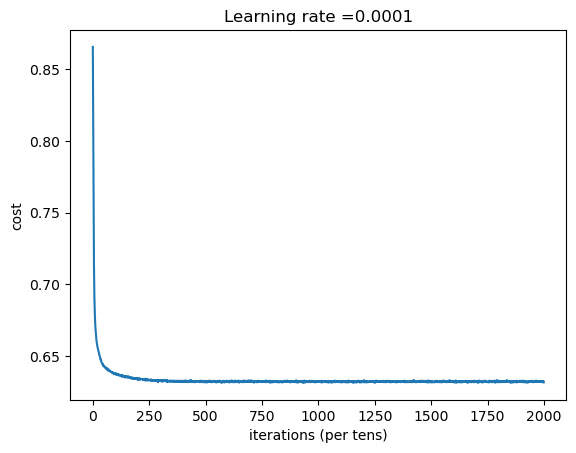

In [31]:
layers_dims = [7, 30, 15, 1]
parameters = model(X_train, Y_train, layers_dims)

In [29]:
Y_test= forward_propagation(X_test, parameters)
# Convert test predictions to binary labels (0 or 1)
with tf.Session() as sess:
    Y_pred = sess.run(Y_test)
Y_pred = (Y_pred > 0.5).astype(int)
print(Y_pred.shape)
print(test_df['PassengerId'].to_numpy().reshape(-1, 1).shape)

result = np.concatenate((test_df['PassengerId'].to_numpy().reshape(-1, 1), Y_pred.T), axis = 1)
result_df = pd.DataFrame(result, columns = ['PassengerId', 'Survived'])
result_df.to_csv('结果/result1.csv', index = False)

(1, 418)
(418, 1)
